#### Neural Style Transfer (NST)
* The content and style image are run through the vgg model (extractor) to get the target content and style.
* An image is generated closer to the content image (or with noise added) - Generated Image
* Loss of the generated image is computed
* Tensorflow graph is intilaised and the generated image





In [40]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image 
import time
import functools

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [41]:
# downloading the data
content_path = 'wolf.jpg'
style_path = 'moon.jpg'

### Basic Utility Functions

In [42]:
def load_img(path):
    max_dim = 512
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # normalizing image
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim

    new_shape = tf.cast(shape*scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [43]:
def imshow(img, title = None):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis = 0)
    plt.imshow(img)

    if title:
        plt.title(title)


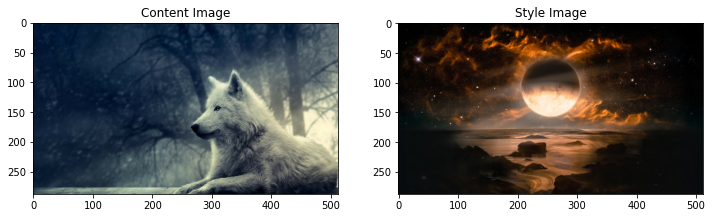

In [44]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

In [67]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [57]:
# we need to keep the pixels btw 0 and 1
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

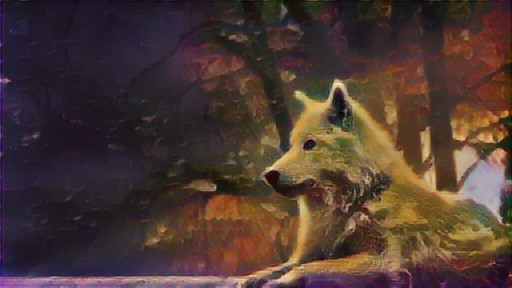

In [46]:
# expected output
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### Transfer Learning using  VGG19

In [47]:
# Loading VGG19 (tf has all google trained models to directly use )
# excluding the last FC layers and classification ayers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [48]:
# vgg layers
for layer in vgg.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [50]:
# building vgg model 
def vgg_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # creating model using Model API
    model = tf.keras.Model([vgg.input], outputs)

    return model

### Computing Style and Content of a given Image

In [49]:
# the style layers chosen here are to compute the gram matrix
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2'] # later layer of the vgg is used, cause it caputures the shapes and figures used in classification

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [51]:
# testing model build function
style_extrator = vgg_model(style_layers)
style_outputs = style_extrator(style_image*255)
style_extrator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [52]:
# Calculating Style Matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijk, bijd->bkd', input_tensor, input_tensor) 
    input_shape = tf.shape(input_tensor)
    num_loco = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_loco)

In [53]:
# returns the content and style of the input image
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_stlayers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0 # inputs are to be in range [0,1]
        preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocess_input)

        style_outputs, content_outputs = (outputs[:self.num_stlayers], outputs[self.num_stlayers:])

        # computing the gram matrix from the style layer outputs
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # creating dictionaries
        content_dict = {content_name : value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style':style_dict}

In [54]:
extractor = StyleContentModel(style_layers, content_layers) # extractor style and content from the input image

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  22594.188
    mean:  415.58594

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  60267.973
    mean:  8697.747

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  333416.62
    mean:  7467.086

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2525525.2
    mean:  131786.58

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  49580.703
    mean:  810.4678

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  1649.1473
    mean:  10.63723


### Computing Style and Content Costs


The Style Cost is given by : 
$J_{style}(S,G) = \sum_{l} \lambda J_{style}(S,G)$

The total loss is given by :
$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

In [55]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [58]:
style_weight=1e-2
content_weight=1e4

In [59]:
# computing content style loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # mean squared error
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

### Generating Image

In [56]:
# the initial generated image 
image = tf.Variable(content_image)

In [60]:
# creating optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1 = 0.99, epsilon= 1e-1)

In [65]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip(image))

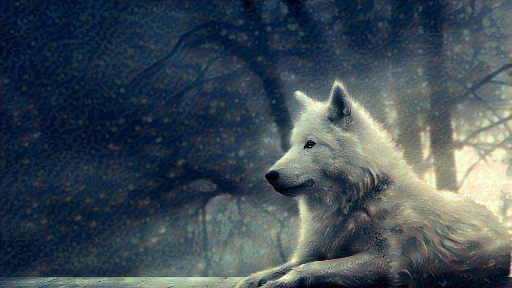

In [68]:
# testing the train function
train_step(image)
tensor_to_image(image)

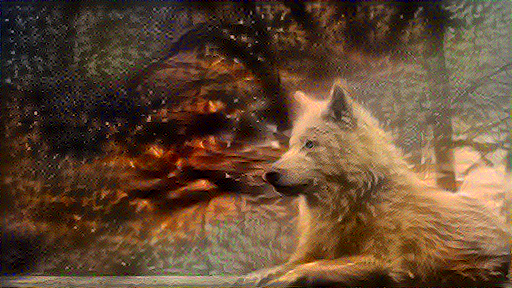

Train step: 100, time - 446.09095644950867


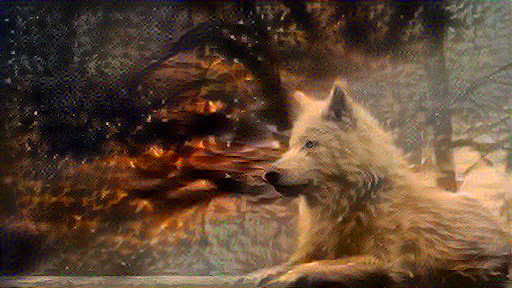

Train step: 200, time - 891.0989441871643


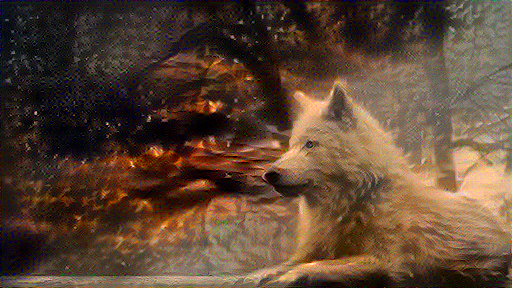

Train step: 300, time - 1346.4530727863312


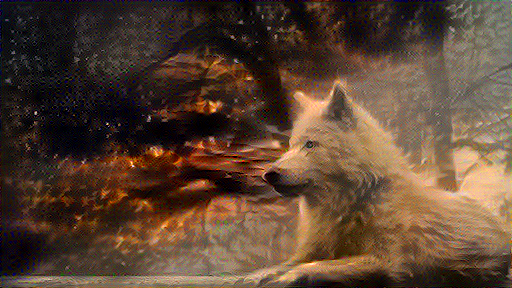

Train step: 400, time - 1816.2347242832184


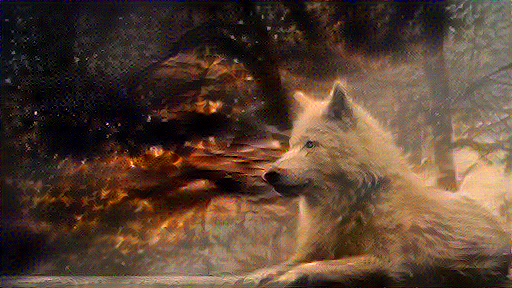

Train step: 500, time - 2288.1123926639557


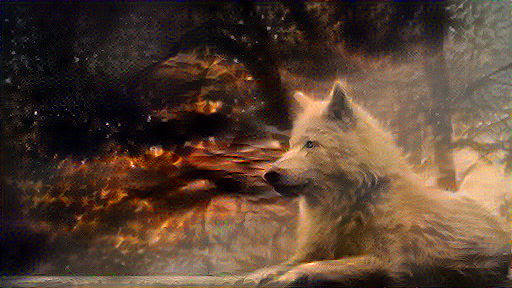

Train step: 600, time - 2759.979481458664


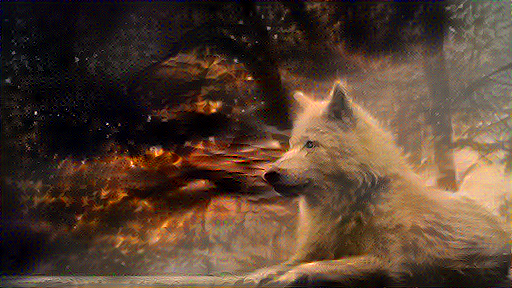

Train step: 700, time - 3233.257570028305


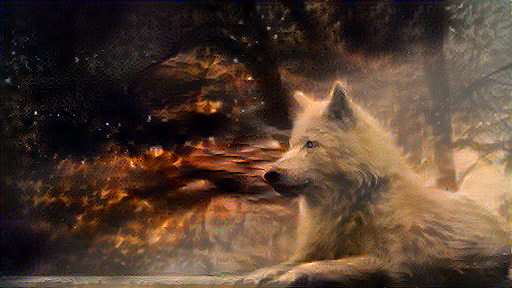

Train step: 800, time - 3681.4987754821777


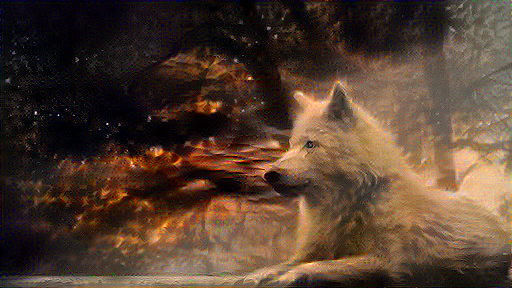

Train step: 900, time - 4130.210612535477


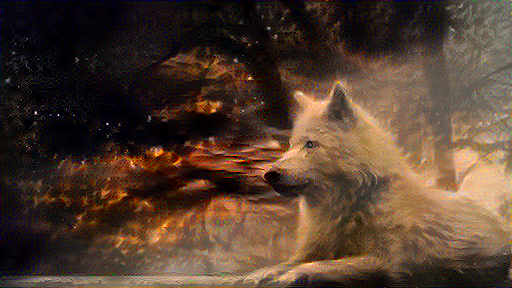

Train step: 1000, time - 4606.5175569057465


ValueError: ignored

In [72]:
import time

start = time.time()
epochs = 10
steps_per_epoch = 100
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    display.display(tensor_to_image(image))
    print('Train step: {}, time - {}'.format(step, time.time()-start))

end = time.time()
print('Total time : {:.f}'.format(end-start))

In [74]:
# saving the result
file_name = 'generated_img.jpeg'
tensor_to_image(image).save(file_name)

In [ ]:
hjg